# 6: Backtesting

## Imports & Settings

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap


In [34]:
N_LONGS = 5

## Load Data

### ML Predictions

In [35]:
DATA_STORE = '../data/assets.h5'
START = '2023'
END = '2024'
with pd.HDFStore(DATA_STORE) as store:
    prices = store['merval/prices'].sort_index()['close'].loc[pd.IndexSlice[START:END]]
prices.index.names = ['date', 'symbol']
prices

date        symbol  
2023-01-02  ALUA.BA       186.000000
            AUSO.BA       384.000000
            BBAR.BA       469.899994
            BHIP.BA        20.299999
            BMA.BA        572.750000
                            ...     
2024-01-02  TGSU2.BA     3045.300049
            TRAN.BA      1234.000000
            TXAR.BA       825.000000
            VALO.BA       223.500000
            YPFD.BA     16530.650391
Name: close, Length: 14152, dtype: float64

In [36]:
predictions_ = pd.read_hdf('../data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)
predictions = (predictions_.loc[~predictions_.index.duplicated()]
				.iloc[:, :10]
				.mean(1)
				.sort_index()
				.dropna()
				.to_frame('prediction'))
tickers = predictions.index.get_level_values('symbol').unique().tolist()

In [37]:
predictions = predictions.join(prices, how='inner')
predictions

prediction         close
symbol  date                                
ALUA.BA 2023-01-02    0.000560    186.000000
        2023-01-03   -0.006649    184.750000
        2023-01-04   -0.000775    186.500000
        2023-01-05    0.001455    190.000000
        2023-01-06    0.006506    194.000000
...                        ...           ...
YPFD.BA 2023-12-21    0.012894  17129.900391
        2023-12-22   -0.001562  16866.599609
        2023-12-26   -0.002530  16425.150391
        2023-12-27   -0.000338  15696.849609
        2023-12-28    0.016580  15968.500000

[14036 rows x 2 columns]

In [38]:
len(predictions.index.get_level_values(0).unique())

58

## Custom backtesting

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = predictions

portfolio_value = []
open_positions = dict()
prev_prices = dict()
profits = dict()
for t in predictions.index.get_level_values(0):
	profits[t] = 0
positions = []
value = 1

dates = df.index.levels[1]
for date in dates:
	daily_df = df.xs(date, level='date')

	# use open_positions to compute total value
	if len(open_positions) > 0:
		value = 0
		for (ticker, alloc) in open_positions.items():
			if ticker == 'cash':
				value += alloc
			else:
				try:
					price = daily_df.loc[ticker, 'close']
				except:
					price = prev_prices[ticker]
				value += price * alloc
				profits[ticker] += (price - prev_prices[ticker]) / price
	portfolio_value.append(value)

	# select next 5 best predictions
	# top_predictions = daily_df[daily_df['prediction'] > 0].nlargest(N_LONGS, 'prediction')
	top_predictions = daily_df[daily_df['prediction'] > 0].nlargest(N_LONGS, 'prediction')
	# top_predictions = daily_df.loc[['PAMP.BA']]

	open_positions = dict()

	if len(top_predictions) == 0:
		open_positions['cash'] = value
	else:
		# update open_positions
		allocation = value / len(top_predictions)
		for ticker in top_predictions.index:
			price = top_predictions.loc[ticker, 'close']
			open_positions[ticker] = allocation / price
			prev_prices[ticker] = price
	
	positions.append(open_positions)

portfolio_df = pd.DataFrame({
    'portfolio_value': portfolio_value,
	'positions': positions
}, index=df.index.levels[1])
portfolio_df.sort_index(inplace=True)
portfolio_df.reset_index(inplace=True)
portfolio_df

In [ ]:
df_expanded = portfolio_df['positions'].apply(pd.Series).fillna(0)
positions_df = pd.concat([portfolio_df['date'], df_expanded], axis=1)
positions_df['date'] = pd.to_datetime(positions_df['date'])
positions_df = positions_df.set_index(['date'])

generar df con la cantidad de dinero en cada ticker

In [ ]:
prices_df = predictions.close.unstack(level='symbol')
prices_df = prices_df.reindex(positions_df.index)
values_df = positions_df.tz_localize(None) * prices_df

Grafico para indicar tickers mas comprados.

In [ ]:
DATA_STORE = '../data/assets.h5'
with pd.HDFStore(DATA_STORE) as store:
    metadata = (store['merval/stocks'].loc[:, ['marketcap', 'sector']]).sector
metadata.to_frame().sector.unique()
metadata['cash'] = 'Unknown'
metadata

ticker
ALUA.BA       Basic Materials
BBAR.BA    Financial Services
BMA.BA     Financial Services
BYMA.BA    Financial Services
GGAL.BA    Financial Services
                  ...        
ROSE.BA            Healthcare
SAMI.BA    Consumer Defensive
SEMI.BA    Consumer Defensive
TGLT.BA                   NaN
cash                  Unknown
Name: sector, Length: 63, dtype: object

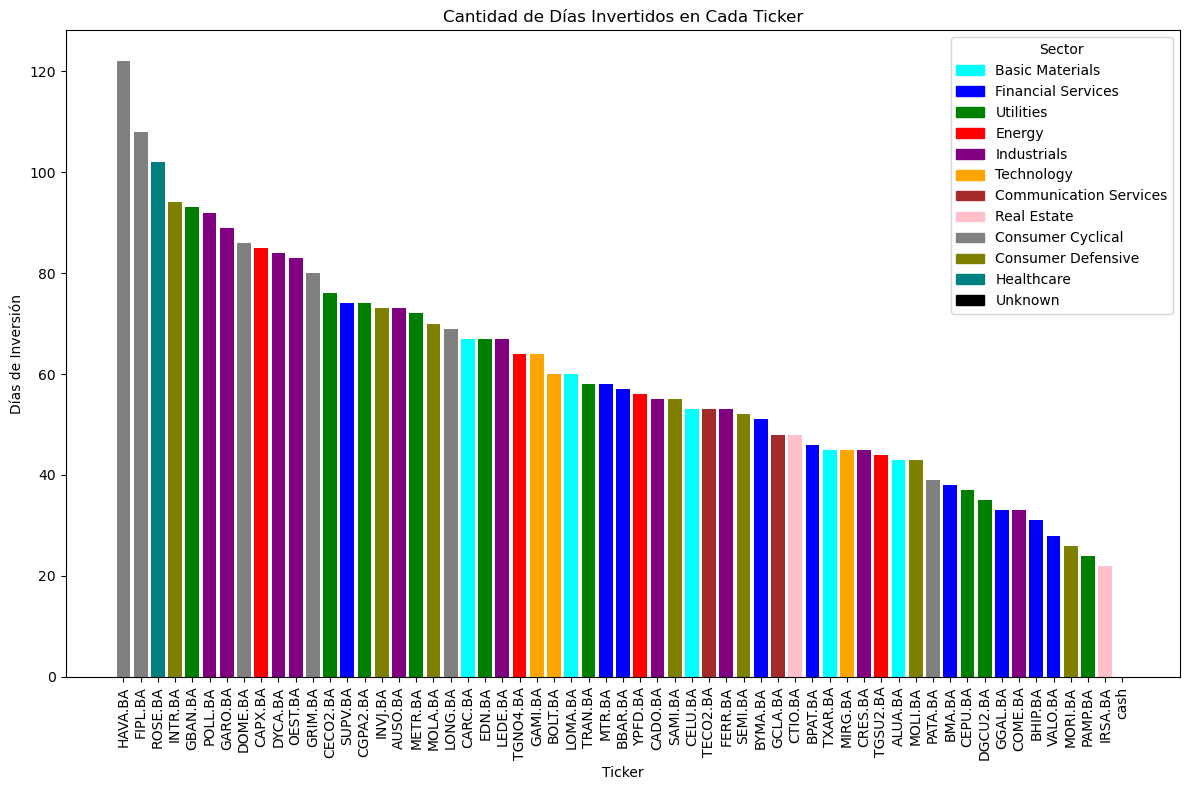

In [ ]:
investment_days = (values_df > 0).sum().sort_values(ascending=False)

# Obtener los sectores correspondientes a los tickers
sectors = metadata.loc[investment_days.index].fillna('Unknown')

sector_colors = {
    'Basic Materials': 'cyan',
    'Financial Services': 'blue',
    'Utilities': 'green',
    'Energy': 'red',
    'Industrials': 'purple',
    'Technology': 'orange',
    'Communication Services': 'brown',
    'Real Estate': 'pink',
    'Consumer Cyclical': 'gray',
    'Consumer Defensive': 'olive',
    'Healthcare': 'teal',
    'Unknown': 'black'
}
colors = sectors.map(sector_colors)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(investment_days.index, investment_days.values, color=colors)
ax.set_xlabel('Ticker')
ax.set_ylabel('Días de Inversión')
ax.set_title('Cantidad de Días Invertidos en Cada Ticker')
plt.xticks(rotation=90)
plt.tight_layout()

# Crear una leyenda personalizada
legend_labels = list(sector_colors.keys())
legend_handles = [plt.Rectangle((0,0),1,1, color=sector_colors[label]) for label in legend_labels]
ax.legend(legend_handles, legend_labels, title='Sector')

# Mostrar el gráfico
plt.show()


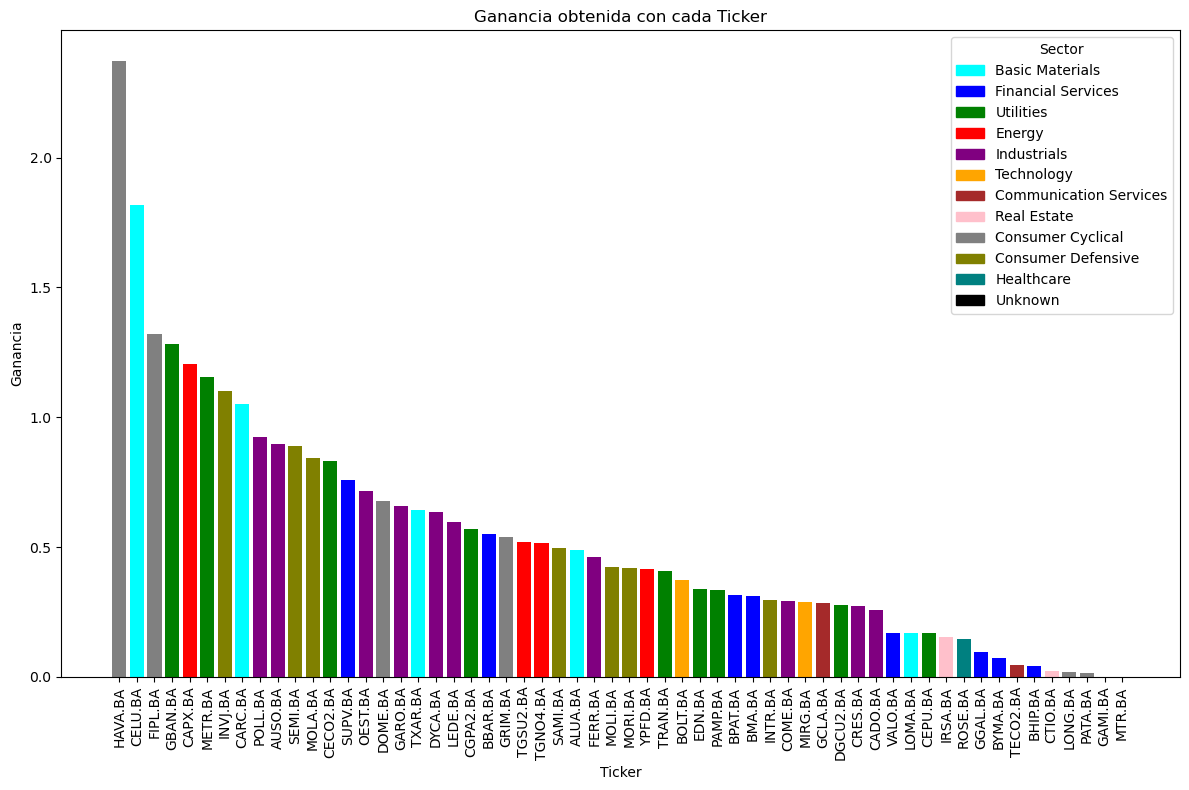

In [ ]:
## REVISAR ESTE GRAFICO, NO TIENE SENTIDO LA MEDICION DE GANANCIA

investment_days = pd.Series(profits).sort_values(ascending=False)

sectors = metadata.loc[investment_days.index].fillna('Unknown')

sector_colors = {
    'Basic Materials': 'cyan',
    'Financial Services': 'blue',
    'Utilities': 'green',
    'Energy': 'red',
    'Industrials': 'purple',
    'Technology': 'orange',
    'Communication Services': 'brown',
    'Real Estate': 'pink',
    'Consumer Cyclical': 'gray',
    'Consumer Defensive': 'olive',
    'Healthcare': 'teal',
    'Unknown': 'black'
}
colors = sectors.map(sector_colors)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(investment_days.index, investment_days.values, color=colors)
ax.set_xlabel('Ticker')
ax.set_ylabel('Ganancia')
ax.set_title('Ganancia obtenida con cada Ticker')
plt.xticks(rotation=90)
plt.tight_layout()

# Crear una leyenda personalizada
legend_labels = list(sector_colors.keys())
legend_handles = [plt.Rectangle((0,0),1,1, color=sector_colors[label]) for label in legend_labels]
ax.legend(legend_handles, legend_labels, title='Sector')

# Mostrar el gráfico
plt.show()


Graficar resultados

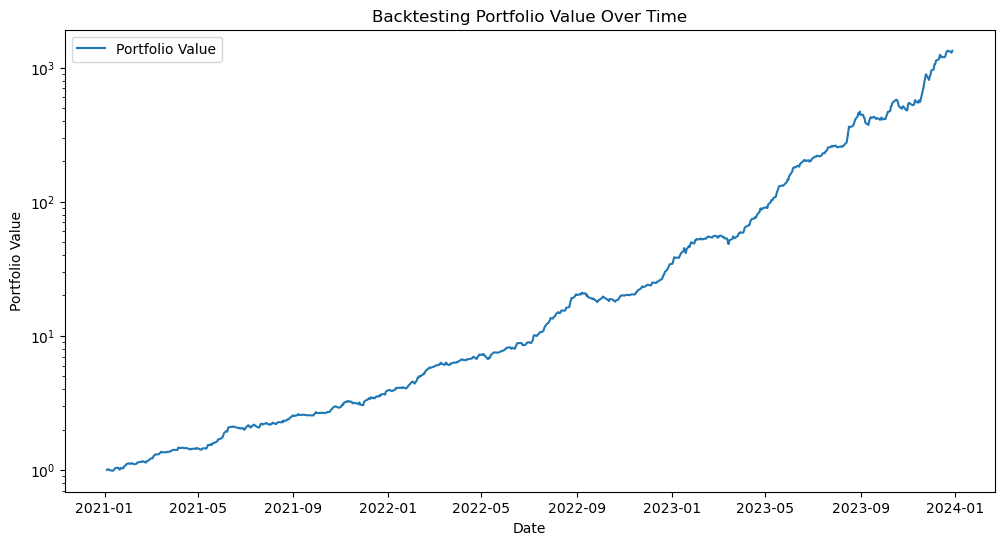

In [ ]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.yscale('log')
plt.title('Backtesting Portfolio Value Over Time')
plt.legend()
plt.show()


In [ ]:
portfolio_df = portfolio_df.set_index(['date'])

In [ ]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['open', 'close', 'low', 'high', 'volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['merval/prices'][ohlcv])


## Metrics in USD

Get dolar "BOLSA" price

In [ ]:
import requests
from datetime import timedelta, datetime

# Función para obtener los tipos de cambio de dolarhoy.com
def get_exchange_rate_history():
    url = "https://api.argentinadatos.com/v1/cotizaciones/dolares/blue"
    response = requests.get(url)
    data = response.json()

    # Filtrar los datos para incluir solo aquellos con casa: "blue"
    exchange_rates = [
        {'date': item['fecha'], 'exchange_rate': item['venta']}
        for item in data
    ]

    # Convertir a DataFrame
    df_exchange_rates = pd.DataFrame(exchange_rates)
    
    # Convertir la columna 'date' a datetime
    df_exchange_rates['date'] = pd.to_datetime(df_exchange_rates['date'], format='%Y-%m-%d')
    
    return df_exchange_rates

exchange_rates = get_exchange_rate_history()

In [ ]:
exchange_rates = exchange_rates.set_index('date')

In [ ]:
exchange_rates = exchange_rates.reindex(portfolio_df.index)
exchange_rates

,exchange_rate
date,
2021-01-04,165
2021-01-05,160
2021-01-06,160
2021-01-07,162
2021-01-08,161
...,...
2023-12-21,990
2023-12-22,995
2023-12-26,995


In [ ]:
a = portfolio_df['portfolio_value'] / exchange_rates['exchange_rate']
portfolio_df['portfolio_value'] = a / a[0]
portfolio_df

,portfolio_value,positions
date,,
2021-01-04,1.000000,"{'GRIM.BA': 0.007827788883449276, 'MTR.BA': 0...."
2021-01-05,1.040315,"{'TECO2.BA': 0.0010453784879024478, 'SEMI.BA':..."
2021-01-06,1.043123,"{'ROSE.BA': 0.017144299470771084, 'INTR.BA': 0..."
2021-01-07,1.023966,"{'SEMI.BA': 0.10036807489132987, 'GRIM.BA': 0...."
2021-01-08,1.017068,"{'MIRG.BA': 0.00012494959194503616, 'GCLA.BA':..."
...,...,...
2023-12-21,220.226173,"{'TXAR.BA': 0.30800863354419855, 'CELU.BA': 0...."
2023-12-22,221.241819,"{'MOLI.BA': 0.10025588643892852, 'CARC.BA': 20..."
2023-12-26,216.976103,"{'GRIM.BA': 0.36345323668740853, 'DYCA.BA': 0...."


## PyFolio Analysis

In [ ]:
returns = portfolio_df['portfolio_value'].pct_change().tz_localize('UTC')

In [ ]:
sp_merval = pd.read_csv('../data/merval.csv')
sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'MERVAL'})
sp_merval['date'] = pd.to_datetime(sp_merval['date'])
# LO DE ARRIBA ES PARA CARGAR EL INDICE MERVAL, LO DE ABAJO PARA USAR EL INDICE PROPIO (rinden casi igual)
# sp_merval = index_df
# sp_merval = index_gral_df

In [ ]:
sp_merval = sp_merval.set_index(['date'])
sp_merval = sp_merval.reindex(portfolio_df['portfolio_value'].index)

# Express results in USD
sp_merval['MERVAL'] = sp_merval['MERVAL'] / exchange_rates['exchange_rate']


In [ ]:
benchmark = sp_merval['MERVAL'].pct_change().tz_localize('UTC')
benchmark = benchmark.reindex(returns.index)

In [ ]:
import yfinance as yf

start_date = START + '-01-01'
end_date = END + '-01-01'
sp500_values = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
sp500_values

[*********************100%%**********************]  1 of 1 completed


Date
2021-01-04    350.543549
2021-01-05    352.957886
2021-01-06    355.068054
2021-01-07    360.343536
2021-01-08    362.396606
                 ...    
2023-12-22    470.664490
2023-12-26    472.651886
2023-12-27    473.506500
2023-12-28    473.685333
2023-12-29    472.314026
Name: Adj Close, Length: 753, dtype: float64

In [ ]:
sp500_benchmark = sp500_values.pct_change().tz_localize('UTC').reindex(returns.index)

### Custom Plots

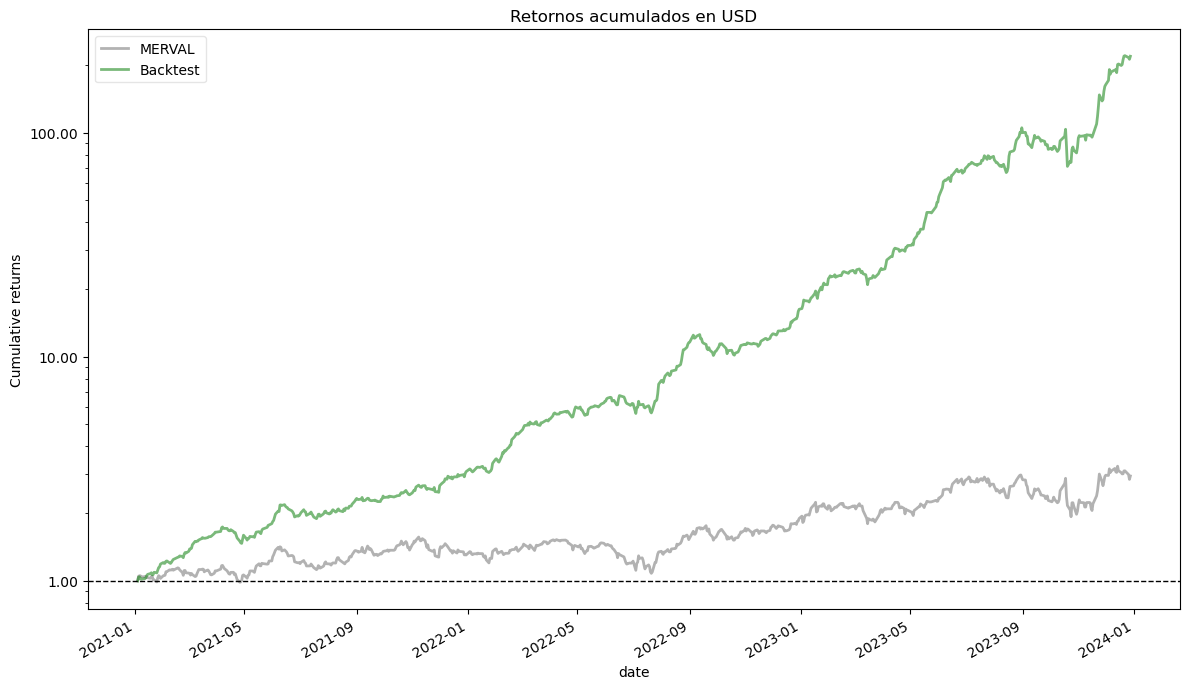

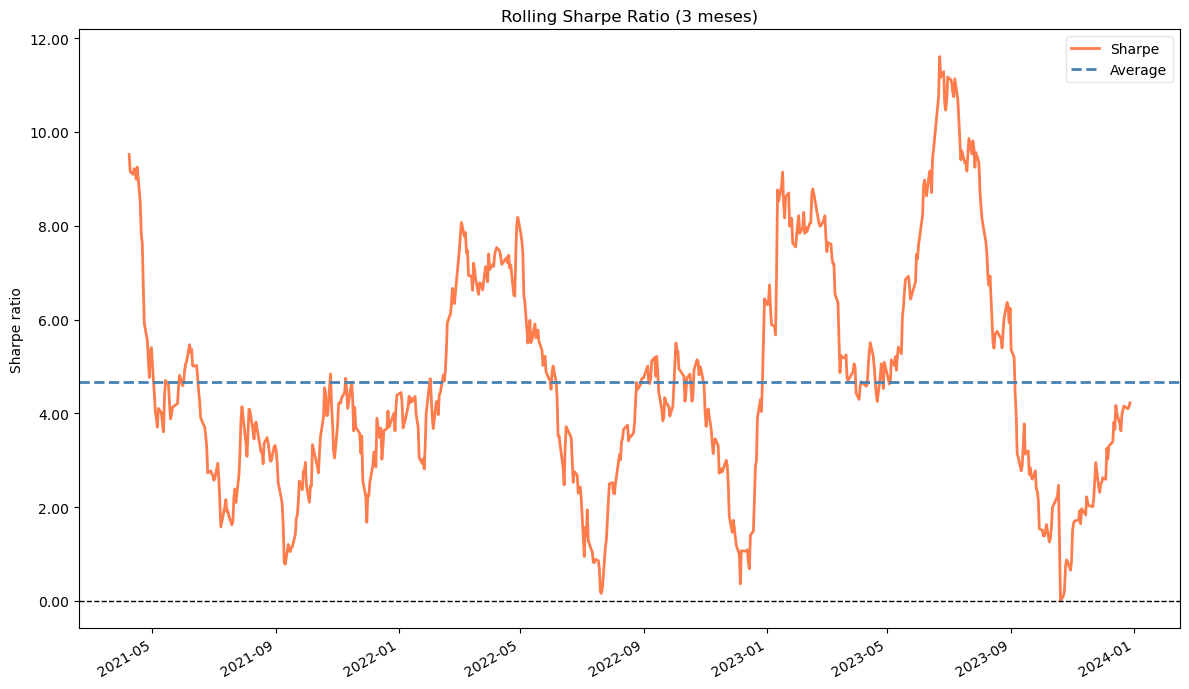

In [ ]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
plot_rolling_returns(
    returns,
    factor_returns=benchmark,
    live_start_date=None,
    logy=True,
    cone_std=2,
    legend_loc='best',
    volatility_match=False,
    cone_function=forecast_cone_bootstrap,
    ax=ax1
)
ax1.set_title('Retornos acumulados en USD')
fig1.tight_layout()

fig2, ax2 = plt.subplots(figsize=(12, 7))
plot_rolling_sharpe(returns, ax=ax2, rolling_window=63)
ax2.set_title('Rolling Sharpe Ratio (3 meses)')
fig2.tight_layout()

plt.show()


Compute anualized variation of merval:

In [ ]:
first_row = sp_merval.iloc[1]
last_row = sp_merval.iloc[-1]
increase = (last_row['MERVAL'] / first_row['MERVAL'])
print(f'The MERVAL index grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The MERVAL index grew by x2.803580
Anualized is: %141.006022


In [ ]:
first_row = portfolio_df.iloc[0]
last_row = portfolio_df.iloc[-1]
increase = (last_row['portfolio_value'] / first_row['portfolio_value'])
print(f'The PORTFOLIO grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The PORTFOLIO grew by x219.862369
Anualized is: %603.555160


In [ ]:
first_row = sp500_values.iloc[0]
last_row = sp500_values.iloc[-1]
increase = (last_row / first_row)
print(f'The SP500 grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The SP500 grew by x1.347376
Anualized is: %110.449297


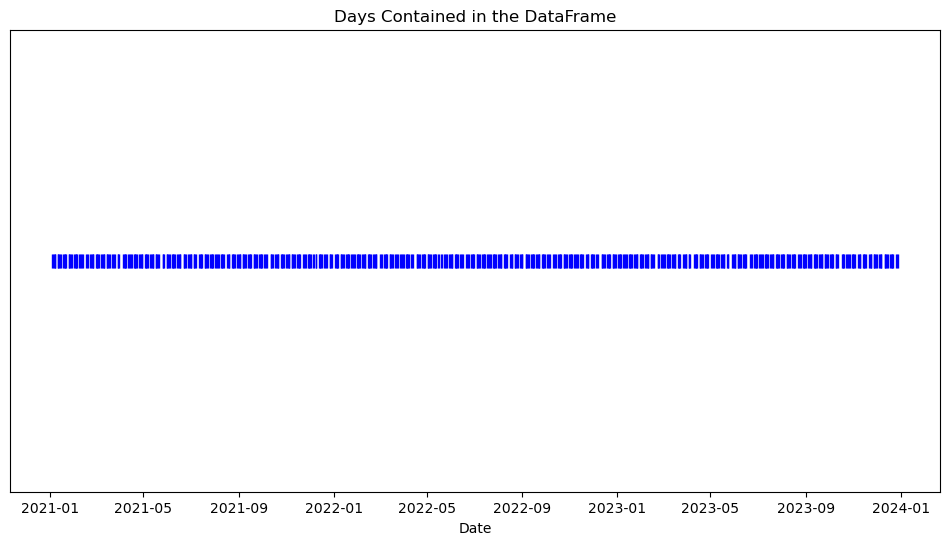

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ejemplo de creación de DataFrame
dates = portfolio_df.index
portfolio_values = portfolio_df['portfolio_value']
df = pd.DataFrame({'portfolio_value': portfolio_values}, index=dates)

# Crear una serie de datos indicando los días contenidos en el DataFrame
days_in_df = df.index

# Graficar los días contenidos en el DataFrame
plt.figure(figsize=(12, 6))
plt.plot(days_in_df, [1]*len(days_in_df), '|', color='blue', markersize=10)  # Use pipe marker to indicate dates
plt.xlabel('Date')
plt.title('Days Contained in the DataFrame')
plt.yticks([])  # Remove y-axis ticks since we only care about the dates
plt.show()


### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.74,2023-08-31,2023-10-20,2023-11-21,59
1,19.34,2022-09-12,2022-09-27,2022-12-01,59
2,16.81,2022-06-16,2022-07-04,2022-07-28,31
3,15.90,2023-07-21,2023-08-14,2023-08-18,21
4,15.54,2021-04-07,2021-04-28,2021-05-27,37


/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.78%,-18.33%,14.28%


Top 10 long positions of all time,max
MTR.BA,100.00%
BOLT.BA,100.00%
DOME.BA,100.00%
GARO.BA,100.00%
MOLA.BA,100.00%
POLL.BA,100.00%
CARC.BA,98.81%
SEMI.BA,95.74%
LONG.BA,91.10%
COME.BA,83.35%


Top 10 short positions of all time,max


Top 10 positions of all time,max
MTR.BA,100.00%
BOLT.BA,100.00%
DOME.BA,100.00%
GARO.BA,100.00%
MOLA.BA,100.00%
POLL.BA,100.00%
CARC.BA,98.81%
SEMI.BA,95.74%
LONG.BA,91.10%
COME.BA,83.35%


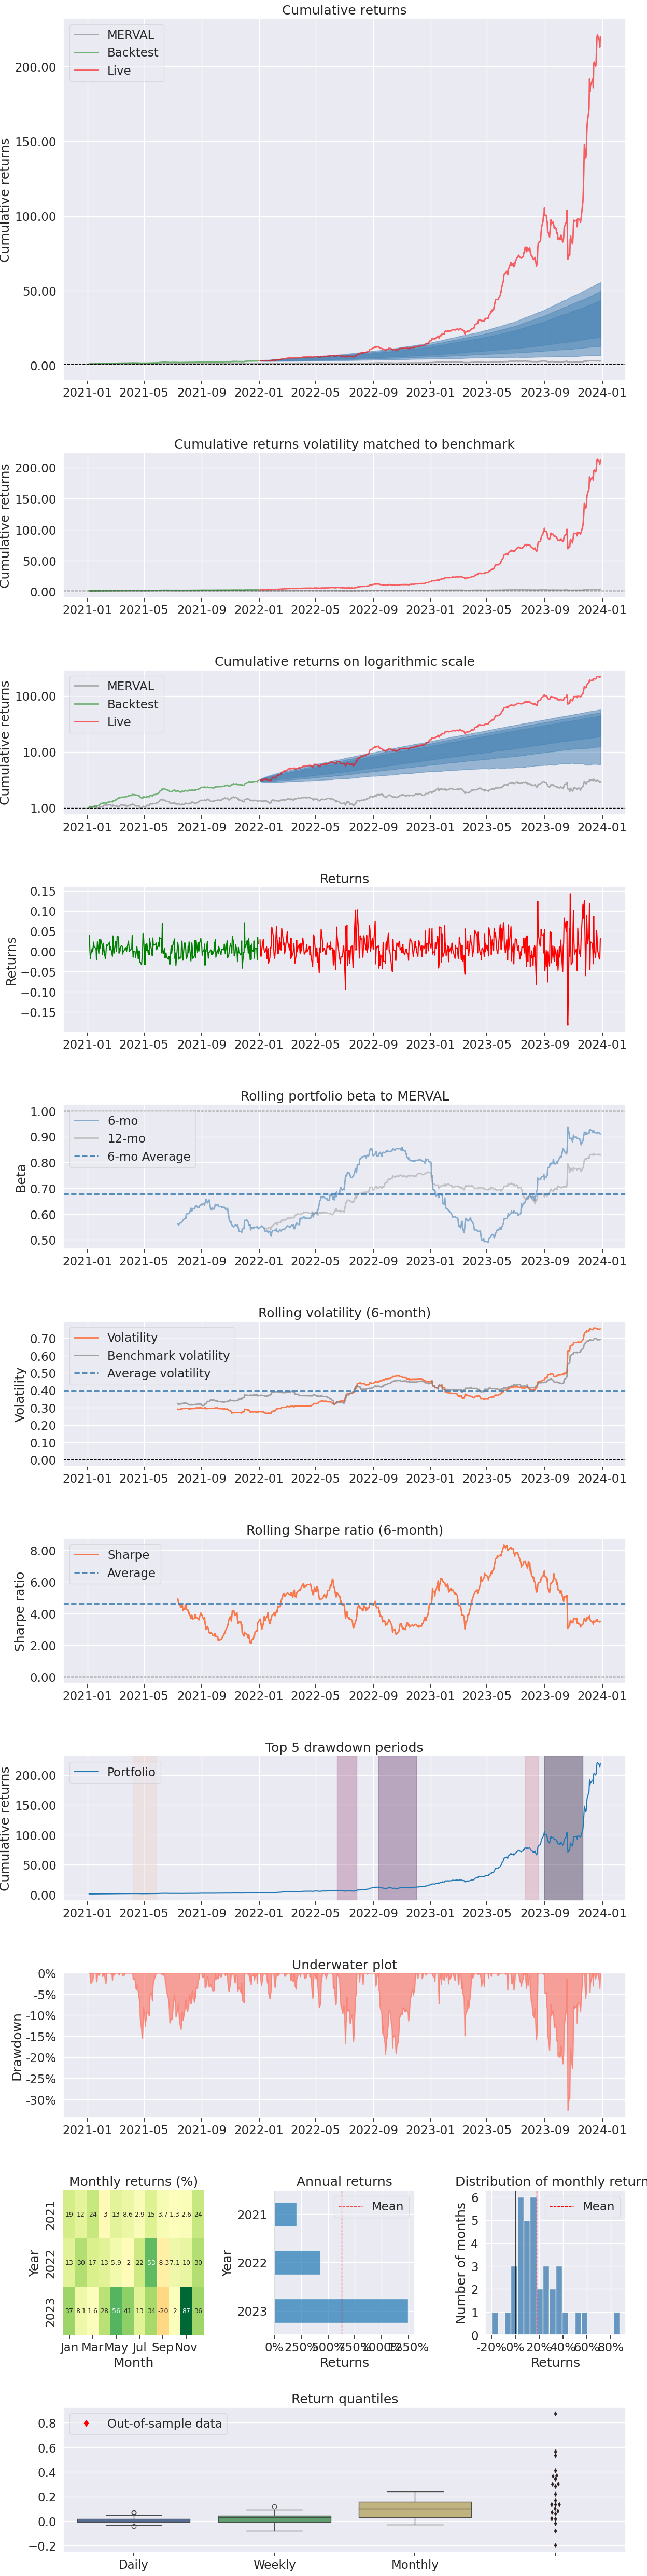

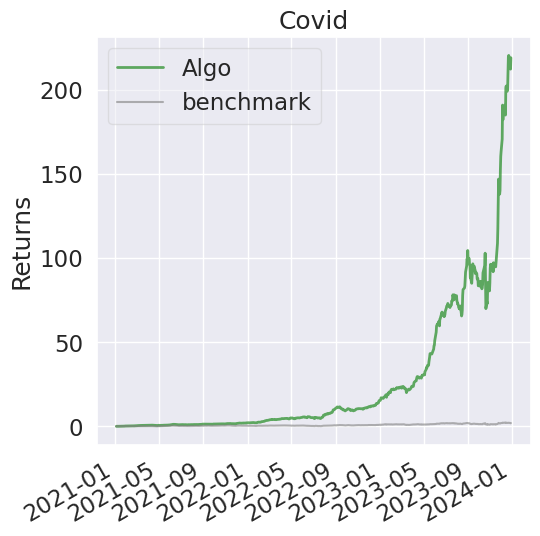

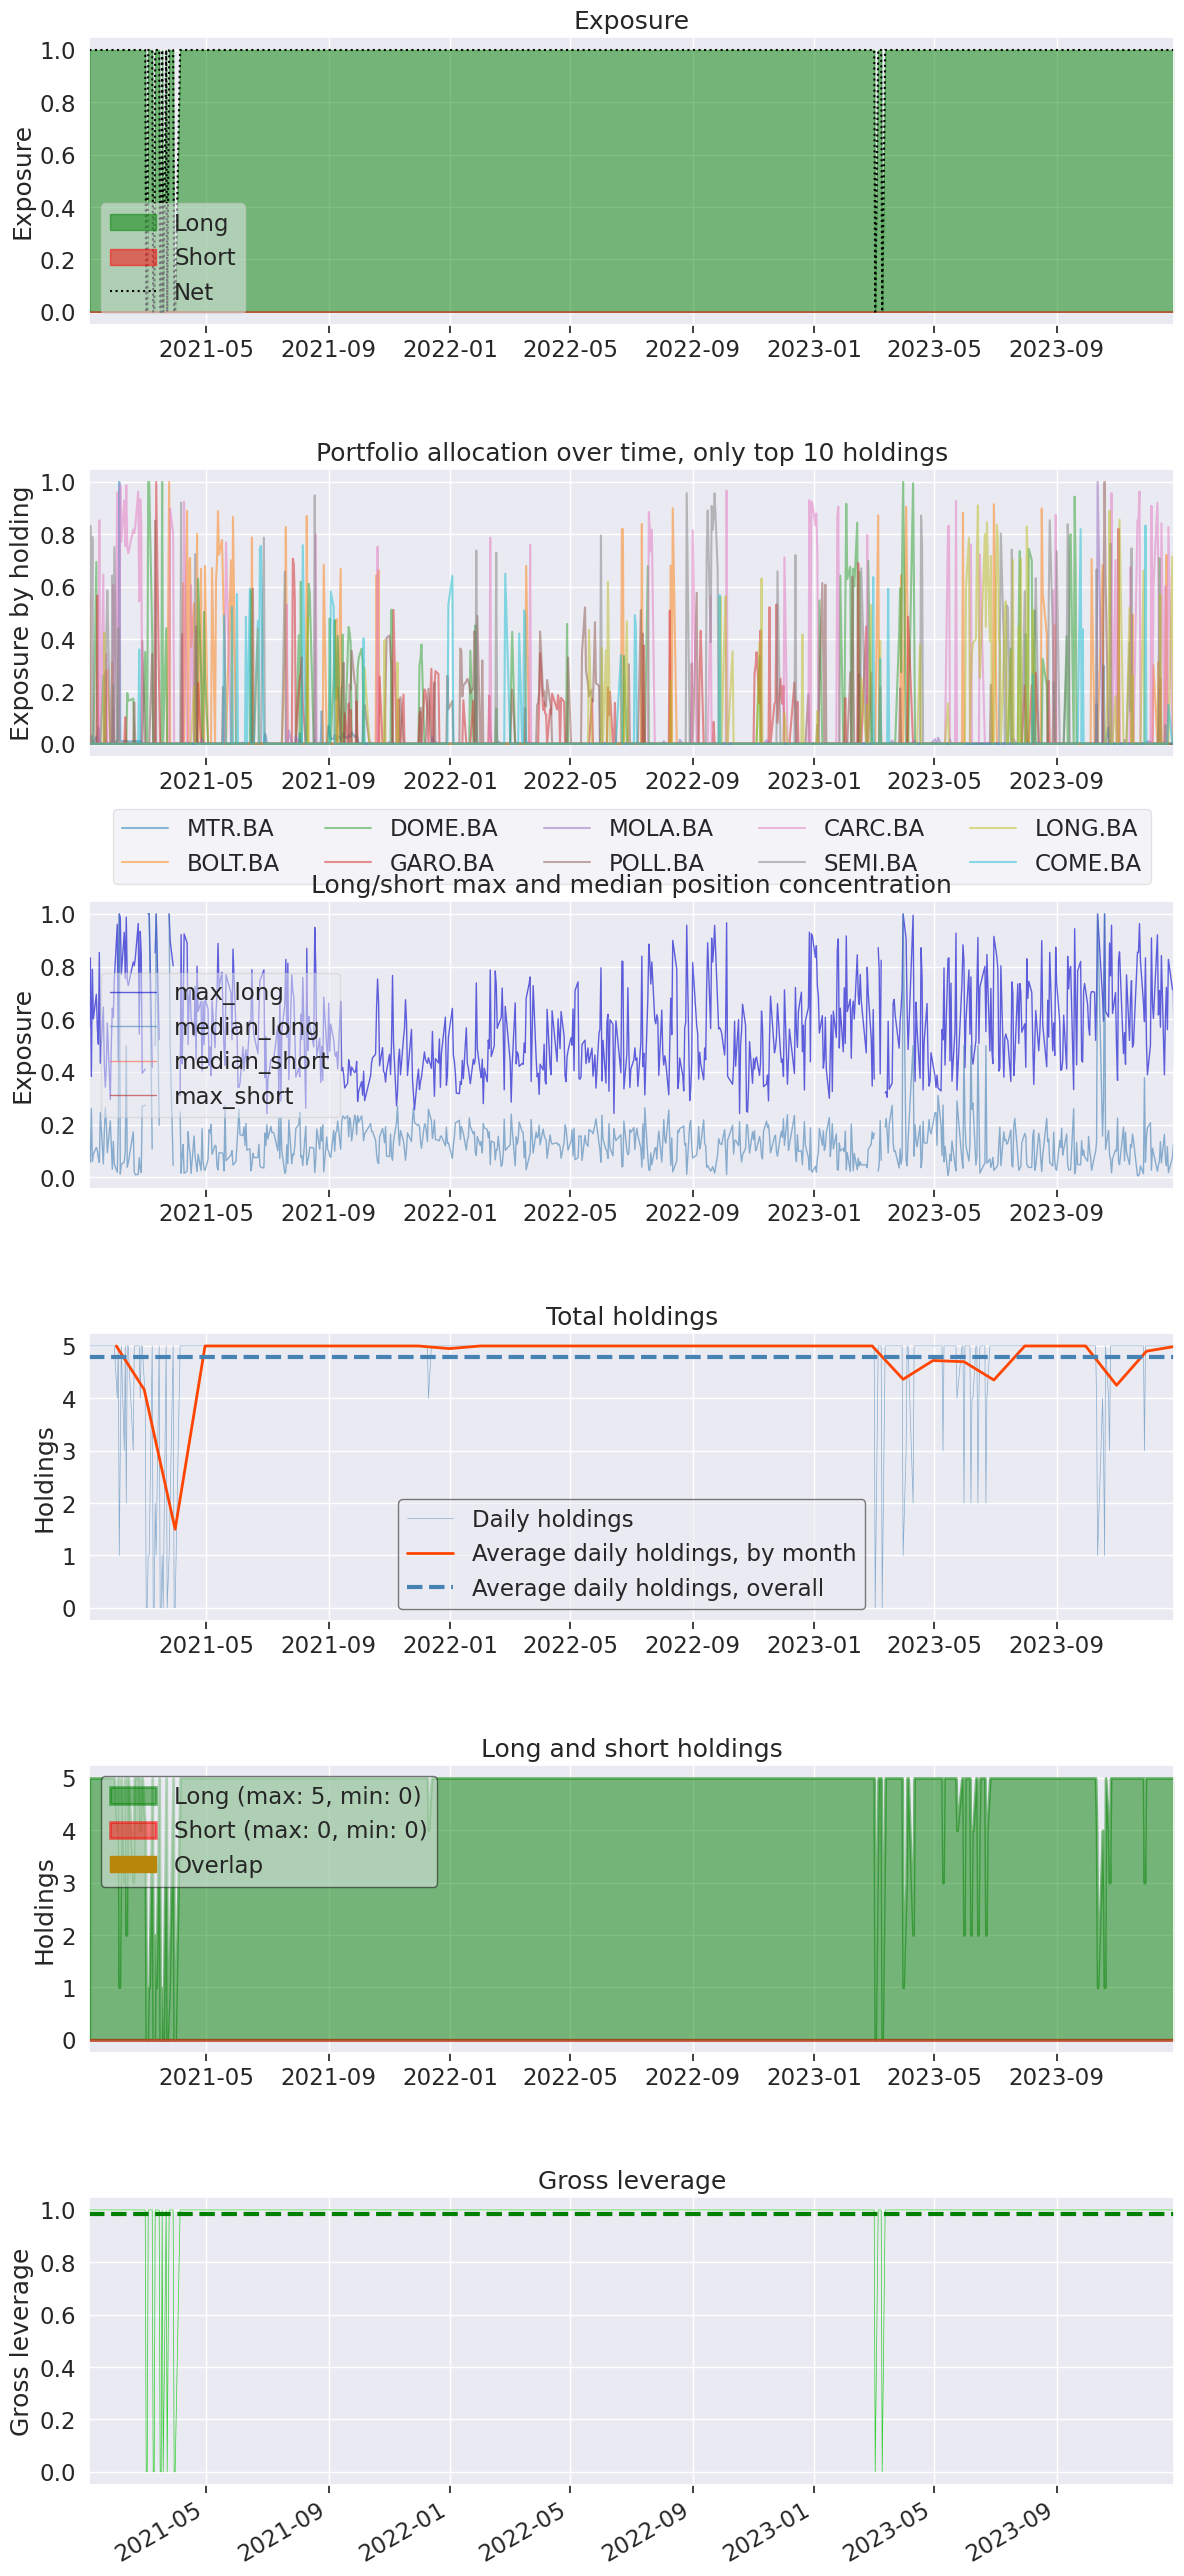

In [ ]:
pf.create_full_tear_sheet(returns, 
                          positions=positions_df.tz_localize('UTC'), 
                          transactions=None,
                          benchmark_rets=benchmark,
                          live_start_date='2022-01-01', 
                          round_trips=True)